In [161]:
import pandas as pd
import seaborn as sns
import regex
from numpy import add
from matplotlib import pyplot as plt
from datetime import datetime

from IPython.display import display # добавил явный импорт на всякий случай

In [162]:
df = r'C:\GitRepo\My-training-Slubik-Stanislav\transactions_dirty.csv'
df = pd.read_csv(df)
display(df.head(10))

,account_number,account_type,date,operation,amount,balance_after,status
0,ACC-100001,checking,2025-09-27 22:17:26,deposit,921.0,2121.0,success
1,ACC-100001,checking,2025-09-27 22:17:26,deposit,607.0,2728.0,success
2,ACC-100001,checking,2025-09-28 22:17:26,deposit,488.0,3216.0,success
3,ACC-100001,checking,28/09/2025 22:17,deposit,129.0,3345.0,success
4,ACC-100001,checking,2025-09-29 22:17:26,deposit,880.0,4225.0,success
5,ACC-100001,checking,2025-09-29 22:17:26,withdraw,NaN,4039.0,success
6,ACC-100001,checking,2025-10-01 22:17:26,withdraw,352.0,3687.0,success
7,ACC-100001,checking,2025-10-01 22:17:26,withdraw,65.0,3622.0,success
8,ACC-100001,checking,2025-10-01 22:17:26,NaN,654.0,4276.0,success
9,ACC-100001,checking,2025-10-01 22:17:26,withdraw,245.0,4031.0,success


In [163]:
# Задание 1 Реализация класса Account


class Account:
    _accont_counter = 1000 # счетчик для генерации уникальных номеров счёта
    
    def __init__(self, account_holder: str, balance: float = 0):
        
        self._account_holder = self._validate_holder_name(account_holder)
        self._balance = self._validate_balance(balance, 'создание счёта')
        
        self._account_number = f'ACC-{Account._accont_counter}'
        Account._accont_counter += 1
        
        self.operations_history = []
    
    
    
    @staticmethod # Проверка имени на соответствие паттерну как Имя Фамилия Отчество
    def _validate_holder_name(account_holder: str):
        account_holder = account_holder.title() # для лучшего соответствия паттерну привел к верхнему регистру
        pattern = r'^[A-ZА-Я][a-zа-я]+(-[A-ZА-Я][a-zа-я]+)?\s+[A-ZА-Я][a-zа-я]+\s+[A-ZА-Я][a-zа-я]$' # от а до я + латинские буквы, пробел(несколько) между ними "Имя Фамилия Отчество" допускается двойное имя
        if not isinstance(account_holder, str) or not regex.match(pattern, account_holder):
            raise ValueError(f'Неверный ввод: "{account_holder}". Пожалуйста, введите имя, фамилию и отчество.')
        return account_holder


    @staticmethod # Проверка операции на соответсвие числовому значению и ее положительности
    def _validate_balance(value: float, type: str):
        if not isinstance(value, (int, float)) or value < 0:
            raise ValueError(f' Операция {type} не выполнена.')
        return float(value)
    
    
    
    def _add_operation(self, operation: str, amount: float, status: str,balance_afther: float):
        '''
        Добавление операции в историю операций
        Каждая операция представляется в виде словаря: 
        текущее время, тип операции, сумма операции, статус операции, баланс после операции
        
        '''
        operation = {
            "timestamp": datetime.now(),
            "operation": operation,
            "amount": amount,
            "status": status,
            "balance_afther" : balance_afther
        }
        self.operations_history.append(operation)
    
    
    
    def deposit(self, amount: float):
        '''
      Метод пополнение счета
      1) Принимает значение
      2) Проверяет значение на соответсвие числовому значению и положительности
      3) Добавляет операцию в историю операций
      
        '''  
        try:
            amount = self.__validate_balance(amount,'пополнение счёта')
            self._balance += amount
            
            self._add_operation('deposit', amount, 'success', self._balance)
            print(f'Счет {self._account_number} пополнен на {amount}')
        
        except ValueError:
            self._add_operation('deposit', amount, 'fail', self._balance)
            print(f'Счет {self._account_number} не пополнен. Попытка пополнить счет на {amount} не удалась.')
    
    
    
    def wihtdraw(self, amount: float):
        '''
        Метод снятия средств
        1) Принимает значение
        2) Проверяет значение на соответсвие числовому значению и положительности
        3) Добавляет операцию в историю операций
        
        '''
        try:
            amount = self.__validate_balance(amount, 'снятие счёта')
            self._balance -= amount
            
            self._add_operation('withdraw', amount, 'success', self._balance)
            print(f'Счет {self._account_number} пополнен на {amount}')
        
        except ValueError:
            self._add_operation('wihtdraw', amount, 'fail', self._balance)
            print(f'Счет {self._account_number} не пополнен. Попытка снять {amount} не удалась.')
        
      
         
    def get_balance(self):
        '''
        Метод, возвращающий текущий баланс
        
        '''
        return self._balance
    
    
    
    def get_history(self):
        '''
        Метод, возвращающий историю операций
        
        '''
        return self.operations_history
    
   

    def plot_history(self):
        '''
        Метод вищуализации истории операций.
        1) Проверяет наличие истории операций
        2) Создает DataFrame из истории операций для работы с ним
        3) Создает график на основе DataFrame
        
        '''
        if not self.operations_history: raise(f'История операций пуста.')
        df = pd.DataFrame(self.operations_history)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        df['month'] = df['timestamp'].dt.strftime('%m')
        
        
        
        df.barplot(df['month'], df['balance_afther'])
          

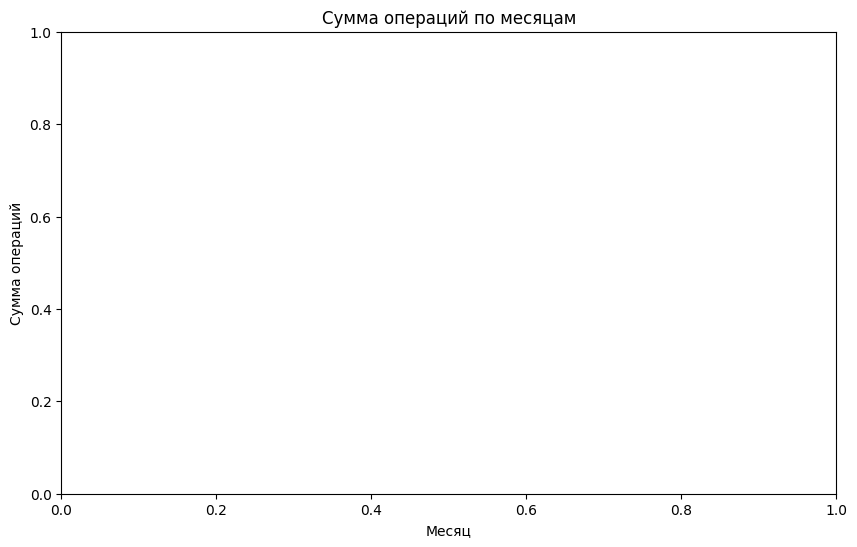

,account_number,account_type,date,operation,amount,balance_after,status,month
0,ACC-100001,checking,NaT,deposit,921.00,2121.00,success,NaN
1,ACC-100001,checking,NaT,deposit,607.00,2728.00,success,NaN
2,ACC-100001,checking,NaT,deposit,488.00,3216.00,success,NaN
3,ACC-100001,checking,NaT,deposit,129.00,3345.00,success,NaN
4,ACC-100001,checking,NaT,deposit,880.00,4225.00,success,NaN
5,ACC-100001,checking,NaT,withdraw,NaN,4039.00,success,NaN
6,ACC-100001,checking,NaT,withdraw,352.00,3687.00,success,NaN
7,ACC-100001,checking,NaT,withdraw,65.00,3622.00,success,NaN
8,ACC-100001,checking,NaT,NaN,654.00,4276.00,success,NaN
9,ACC-100001,checking,NaT,withdraw,245.00,4031.00,success,NaN


In [168]:
from dateutil import parser

def parse_date(date_str):
    try:
        return parser.parse(date_str, fuzzy=True)
    except:
        return pd.NaT

df['date'] = df['date'].apply(parse_date)

df['month'] = df['date'].dt.strftime('%m')
add_months = df.groupby('month')['balance_after'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data = add_months, x ='month', y ='balance_after', palette = 'Blues_r', ax=ax)
ax.set_title('Сумма операций по месяцам')
ax.set_xlabel('Месяц')
ax.set_ylabel('Сумма операций')
plt.show()
display(df.head(50))

